# Imports

In [1]:
import os
from tqdm import tqdm 

import tensorflow as tf
# import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print('running tf: ', tf.__version__)

2024-06-29 02:29:40.327884: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 02:29:40.345874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 02:29:40.345890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 02:29:40.346362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-29 02:29:40.349462: I tensorflow/core/platform/cpu_feature_guar

running tf:  2.15.1


In [2]:
# from classification_models.keras import Classifiers

# SeResNeXT50, preprocess_fn = Classifiers.get('seresnext50')

# Config

In [3]:
DEBUG = False

NUM_CLASSES = 2
IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 30

MAX_SEQ_LENGTH = 16
NUM_FEATURES = 1280

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Dataloaders

**TO DO**
- Better Frame Sampling
- Augs

In [4]:
def read_frames_from_folder(folder_path):
    folder_path = folder_path.numpy().decode('utf-8')
    # Get list of all frame files
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    
    # Take the last num_frames frames if there are more frames
    if len(frame_files) > MAX_SEQ_LENGTH:
        frame_files = frame_files[-MAX_SEQ_LENGTH:]
    
    frames = []
    for frame_file in frame_files:
        img = image.load_img(frame_file, target_size=(IMG_SIZE, IMG_SIZE), interpolation='bicubic',)
        img_array = image.img_to_array(img)
        
        # preprocess/normalize - had to do it here for older tf versions
        # img_array = preprocess_fn(img_array)
        
        frames.append(img_array)
    
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)

    # If fewer than num_frames, pad with zeros
    if len(frames) < MAX_SEQ_LENGTH:
        padding = tf.zeros((MAX_SEQ_LENGTH - len(frames), IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)
        frames = tf.concat([padding, frames], axis=0)
        
    return frames

def load_video_from_folder(file_path, label = None):
    video = tf.py_function(func=read_frames_from_folder, inp=[file_path], Tout=tf.float32)
    video.set_shape([MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3])
    
    if label is None:
        return video
        
    label = tf.cast(label, dtype=tf.int32)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return video, label

def create_dataset(file_paths, labels, shuffle_buffer_size=None):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # shuffle training data
    if shuffle_buffer_size:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    dataset = dataset.map(load_video_from_folder, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [6]:
freeway_train_path = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/freeway/train'
road_train_path = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/road/train'
freeway_train_csv = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/freeway_train.csv'
road_train_csv = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/road_train.csv'

freeway_df = pd.read_csv(freeway_train_csv)
road_df = pd.read_csv(road_train_csv)

# Add the directory path to the file names
freeway_df['file_name'] = freeway_df['file_name'].apply(lambda x: os.path.join(freeway_train_path, x))
road_df['file_name'] = road_df['file_name'].apply(lambda x: os.path.join(road_train_path, x))

# Combine dataframes
all_df = pd.concat([freeway_df, road_df])

if DEBUG:
    all_df = all_df[:20]

In [7]:
# Split into train and validation sets
train_df, val_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['risk'])

# Create datasets
train_dataset = create_dataset(train_df['file_name'].values, train_df['risk'].values, shuffle_buffer_size=len(train_df))
val_dataset = create_dataset(val_df['file_name'].values, val_df['risk'].values)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for val: {len(val_df)}")

Total videos for training: 16
Total videos for val: 4


2024-06-28 23:27:13.069625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 23:27:13.069718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 23:27:13.086480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Sanity Check

In [8]:
# Iterate through the train dataset
for videos, labels in train_dataset.take(1):
    print(videos.shape, labels.shape)

# Iterate through the validation dataset
for videos, labels in val_dataset.take(1):
    print(videos.shape, labels.shape)

(4, 16, 224, 224, 3) (4, 2)
(4, 16, 224, 224, 3) (4, 2)


# Model

In [9]:
# from classification_models.keras import Classifiers

# SeResNeXT50, preprocess_fn = Classifiers.get('seresnext50')

In [5]:
def FeatureExtractor():
    base_model = tf.keras.applications.EfficientNetV2M(
        weights='imagenet', 
        include_top=False,  
        input_shape=(IMG_SIZE, IMG_SIZE, 3), 
        pooling=None,
    )

#     base_model = SeResNeXT50(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)
#     preprocess_layer = tf.keras.layers.Lambda(lambda x: preprocess_fn(x))
    
    base_model.trainable = True

    model = tf.keras.models.Sequential([
        tf.keras.Input((IMG_SIZE, IMG_SIZE, 3)),
#         preprocess_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return model

tf.keras.backend.clear_session()
model = FeatureExtractor()
model.summary()

2024-06-29 02:30:01.808894: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 02:30:01.808992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 02:30:01.826070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, 7, 7, 1280)        53150388  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
Total params: 53155508 (202.77 MB)
Trainable params: 52860916 (201.65 MB)
Non-trainable params: 294592 (1.12 MB)
_________________________________________________________________


In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer Normalization and Multi-Head Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)  # Shape: (sequence_length, 256)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)  # Shape: (sequence_length, 256)
    x = tf.keras.layers.Dropout(dropout)(x)  # Shape: (sequence_length, 256)
    res = tf.keras.layers.Add()([x, inputs])  # Shape: (sequence_length, 256)

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)  # Shape: (sequence_length, 256)
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)  # Shape: (sequence_length, 256)
    x = tf.keras.layers.Dropout(dropout)(x)  # Shape: (sequence_length, 256)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)  # Shape: (sequence_length, 256)
    return tf.keras.layers.Add()([x, res])  # Shape: (sequence_length, 256)

In [7]:
def SeqModel():
    inputs = tf.keras.Input((MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3))
    feature_extractor = FeatureExtractor()
    
    time_wrapper = tf.keras.layers.TimeDistributed(feature_extractor)(inputs)
    image_features = tf.keras.layers.Dense(256, activation="relu")(time_wrapper)


    head_size = 64
    num_heads = 4
    ff_dim = 256
    dropout = 0.2
    x = transformer_encoder(image_features, head_size, num_heads, ff_dim, dropout)  
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax',)(x)
    
    return tf.keras.Model(inputs, outputs)

tf.keras.backend.clear_session() 
model = SeqModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 16, 1280)             5315550   ['input_1[0][0]']             
 ributed)                                                 8                                       
                                                                                                  
 dense (Dense)               (None, 16, 256)              327936    ['time_distributed[0][0]']    
                                                                                                  
 layer_normalization (Layer  (None, 16, 256)              512       ['dense[0][0]']           

## Optimize & Compile

In [8]:
def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

def get_lr_callback():       
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

Learning rate schedule: 0.0005 to 0.032 to 0.000305


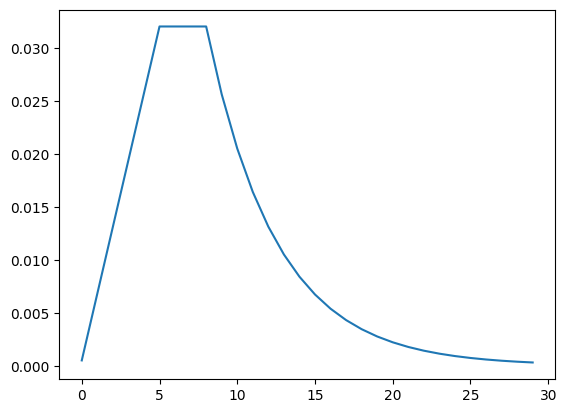

In [14]:
lr_start   = 0.0005
lr_max     = 0.002 * 16
lr_min     = 0.00001
lr_ramp_ep = 5
lr_sus_ep  = 3
lr_decay   = 0.8

rng = [i for i in range(8 if EPOCHS<8 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [15]:
# callbacks
weights_save_path = './weights/training_3/epoch-{epoch:02d}.weights.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_save_path, 
                                                save_best_only=False, 
                                                save_weights_only=True,
                                                verbose=1,
                                                monitor='val_loss', 
                                                mode='min')

csv_logger = tf.keras.callbacks.CSVLogger('history.csv')

learning_rate_reduction= tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 

# callbacks = [checkpoint, learning_rate_reduction]

callbacks = [checkpoint, csv_logger, get_lr_callback()]

In [16]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),       
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc', multi_label=False, label_weights=[0, 1]),
]

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

# Train

In [18]:
EPOCHS = 5 if DEBUG else EPOCHS

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/5


2024-06-28 23:29:03.440395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/time_distributed/sequential/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-28 23:29:12.280157: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-28 23:29:12.287487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-28 23:29:12.322478: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-28 23:29:13.740433: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f16843ec980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-28 23:29:13.740446: I external/local_xla/xla/service/service.cc:176]   Str

4/4 [==============================] - ETA: 0s - loss: 2.5484 - accuracy: 0.3750 - precision: 0.3750 - recall: 0.3750 - auc: 0.3000
Epoch 1: saving model to ./weights/training_3/epoch-01.weights.h5
4/4 [==============================] - 58s 2s/step - loss: 2.5484 - accuracy: 0.3750 - precision: 0.3750 - recall: 0.3750 - auc: 0.3000 - val_loss: 2.2636 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 4.4390 - accuracy: 0.4375 - precision: 0.4375 - recall: 0.4375 - auc: 0.3000
Epoch 2: saving model to ./weights/training_3/epoch-02.weights.h5
4/4 [==============================] - 11s 2s/step - loss: 4.4390 - accuracy: 0.4375 - precision: 0.4375 - recall: 0.4375 - auc: 0.3000 - val_loss: 48.5608 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.5000 - lr: 0.0068
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 3.8843 - acc

## Plots

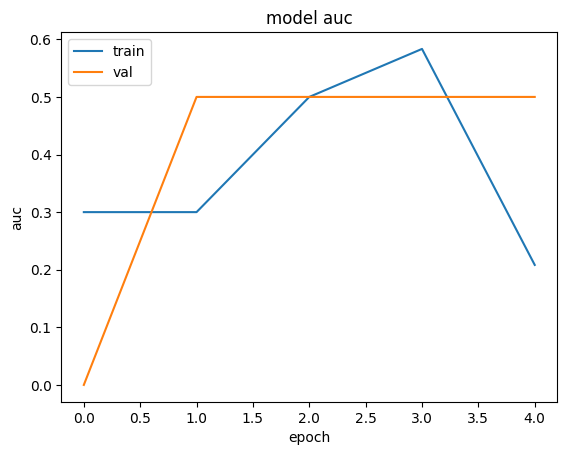

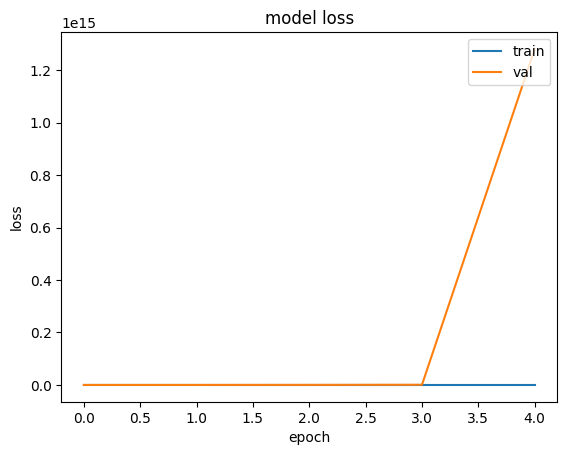

In [19]:
plt.figure(1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Inference

In [9]:
EPOCHS = 8
WEIGHT_PATH = f'./weights/training_3/epoch-{EPOCHS:02d}.weights.h5'
print(WEIGHT_PATH)
model.load_weights(WEIGHT_PATH)

./weights/training_3/epoch-08.weights.h5


In [10]:
def create_test_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_video_from_folder, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def run_inference(dataset, model):
    predictions = []
    for videos in dataset:
        preds = model.predict(videos, verbose = 0)
        predictions.extend(preds)
    return predictions

In [11]:
# Load the sample submission file
submission_df = pd.read_csv('/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/sample_submission.csv')

if DEBUG:
    submission_df = submission_df[:5]

# Get test file names
test_files = submission_df['file_name'].values

# Paths to test data
freeway_test_path = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/freeway/test'
road_test_path = '/mnt/storage2/Sabbir/VideoClassification/Video_Classification_Pipeline/Data/road/test'

# Create list of file paths
test_file_paths = []
for file_name in test_files:
    if 'road' in file_name:
        test_file_paths.append(os.path.join(road_test_path, file_name))
    elif 'freeway' in file_name:
        test_file_paths.append(os.path.join(freeway_test_path, file_name))
        
        
test_dataset = create_test_dataset(test_file_paths)

preds = run_inference(test_dataset, model)
positive_probs = [pred[1] for pred in preds]

submission_df['risk'] = positive_probs
submission_df.to_csv('submission.csv', index=False)

2024-06-29 02:31:09.694839: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-29 02:31:09.726948: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-29 02:31:09.879913: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
submission_df.head()

,file_name,risk
0,road_0179,0.016152
1,road_0180,0.039322
2,road_0181,0.084891
3,road_0182,0.000295
4,road_0183,0.036873


In [13]:
from datetime import datetime

print('notebook finished on: ', datetime.now())

notebook finished on:  2024-06-29 02:32:47.688046
